## Regression of Nino index onto US Precip
Dennis L. Hartmann  January 11, 2023  for ATMS 552


In [25]:
### First select needed software
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf
from scipy.io import loadmat
import scipy.signal as sig
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import pandas as pd
import netCDF4 as nc
import warnings
from cartopy import config

## Some information on the data
Data are both montly, but precip starts in 1948 and nino indices in 1950, so we will want to skip the first two years of nino data
The precip data has 846 months 846/12 which is 70 and a half years, so the data set stops in the middle of 2018, not sure if it has been extended

So we need to cut off the first 24 months of the precip series and the last 6 months.  68 years
We need to pick just the first 68 years of the nino data set

The precip data are high spatial resolution, but only cover the land area of the lower 48 states = CONUS.

nin34 shape  (816, 1)
nin34 len 816
lonp  (301,)
lonp(145)  266.125
lonp  (301,)
(846, 120, 300)
(120, 300)
prcpmp  (120, 301)
max prcp nan
xx  (120,)


/home/disk/eos10/dennis/anaconda3/envs/atms552/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/disk/eos10/dennis/anaconda3/envs/atms552/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/disk/eos10/dennis/anaconda3/envs/atms552/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


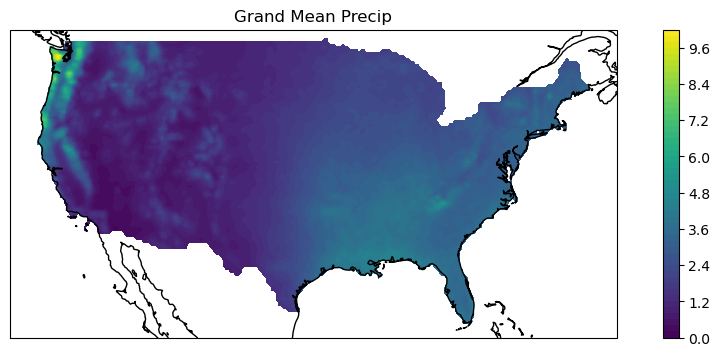

In [26]:
### Next open data sets and read them in
# nino index
fileprcp = '/home/disk/eos10/dennis/precip552.d/precip.V1.0.mon.mean2020.nc'
# Nino_3-4.mat contains nino3, nino4, nino34 anom34 etc.  Monthly data starts in 1950
filenino = '/home/disk/eos10/dennis/precip552.d/Nino_3-4.mat'  
nino = loadmat(filenino,appendmat=False)
var='nino34'
nin34 = [[element for element in upperElement] for upperElement in nino[var]]
print('nin34 shape ',np.shape(nin34))
# make a time index for months
print('nin34 len',len(nin34))
time = pd.Series(range(0,len(nin34)))
time = 1950 + time/12 +1/12.
nin_title= var 
de_trend = True
if de_trend == True:
    nin34 = sig.detrend(nin34,axis=0)
    nin_title = var + ' detrended'
plotnino = False
if plotnino:
    plt.figure()
    plt.plot(time,nin34)
    plt.title(nin_title)
    plt.ylabel('SST Anomaly \N{DEGREE SIGN}C')
    plt.xlim([1950, 2020])
    plt.ylim([-3, 3])
    plt.grid()
    plt.show()

# open  using netCDF4 and xarray
with warnings.catch_warnings(record=True):
    ds = nc.Dataset(fileprcp)
    #print(ds)
    # open using xarray
    ds_disk = xr.open_dataset(fileprcp)  # this worked
    ds_disk   # this tells you what is in the data set.  Gives time in year-mn-da
    prcp = ds_disk.precip
    lon = ds_disk.lon
    lonp = np.empty(len(lon)+1)
    lonp[0:len(lon)] = lon
    lonp[len(lon)]= lon[len(lon)-1]+lon[1]-lon[0]
    print('lonp ',np.shape(lonp))
    print('lonp(145) ',lonp[144])
    print('lonp ',np.shape(lonp))
    lat = ds_disk.lat
    print(np.shape(prcp))
    prcpm = np.nanmean(prcp,0)
    print(np.shape(prcpm))
    prcpmp = np.empty([len(lat),len(lon)+1])
    print('prcpmp ',np.shape(prcpmp))
    prcpmp[:,0:len(lon)]= prcpm
    prcpmp[:,len(lon+1)]= prcpm[:,0]
    xx = prcpm[:,0]
    print('max prcp',np.max(prcpmp))
    print('xx ',np.shape(xx))#  Next read in the precipitation data

old_way = False
if old_way:
    ds = nc.Dataset(fileprcp)
    # the data set contains time(), lon(300,), lat(120,), precip(846, 120, 300)
    # lat_range: [20.125 49.875],  lon_range: [230.125 304.875]
    interog_data = False
    if interog_data:
        print(ds)
        for dim in ds.dimensions.values():
            print(dim)
        for var in ds.variables.values():
            print(var) 
            print(ds['precip'])
    prcp = ds['precip'][:]
    time = ds['time'][:]
    lon  = ds['lon'][:]
    lat  = ds['lat'][:]
    prcp = np.asarray(prcp, dtype = 'float')
    print(np.shape(prcp))
    print(type(prcp))
    pmax = np.max(prcp)
    print('pmax ',pmax)
    
# plot the grand mean
# let's try to plot a monthly mean
plt.figure(figsize=(12, 4), dpi=100)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-90))

plt.contourf(lon, lat, prcpm, 60,
             transform=ccrs.PlateCarree())
plt.title('Grand Mean Precip')
ax.coastlines()
plt.colorbar()
#plt.colorbar(location='bottom')
plt.show()

In [27]:
# pick the subset of data we want
# 68 years of nino data starts in 1950
yrmx=68
nin = nin34[0:yrmx*12]
print('nin len ',len(nin))
print('nin years ',len(nin)/12.)
# ok now prcp 68 years starting in 1950
print('prcp size ',np.shape(prcp))
pmx=24+yrmx*12
print('pmx ',pmx)
prcp = prcp[24:pmx,:,:]
print('prcp size ',np.shape(prcp))
print('prcp type ',type(prcp))
prcp = xr.DataArray.to_numpy(prcp)
print('prcp type ',type(prcp))

nin len  816
nin years  68.0
prcp size  (846, 120, 300)
pmx  840
prcp size  (816, 120, 300)
prcp type  <class 'xarray.core.dataarray.DataArray'>
prcp type  <class 'numpy.ndarray'>


## next let's remove the average annual cycle


In [28]:
# Start with nin, then prcp
# let's begin with something for which I should know the answer.
do_test = False
if do_test == True:
    t = pd.Series(range(0,50*12))
    x = np.cos(t*np.pi*2/12.)
    x = np.asarray(x,dtype='float')
    plt.plot(t,x)
    print('t ',np.shape(t))
    print('x ',np.shape(x))
    plt.figure()
    nyrs=int(len(x)/12)
    x = np.reshape(x, (nyrs,12))
    xm= np.nanmean(x,0)  # this implies that the first index varies fastest
    print('xm ', np.shape(xm))
    plt.plot(xm)
#
nin = np.asarray(nin, dtype = 'float')

nin = np.reshape(nin, (yrmx,12))
ninm = np.nanmean(nin,0)
out_ninm = False
if out_ninm:
    print('ninm ',np.shape(ninm))
    plt.figure()
    plt.plot(ninm)
    plt.title('ninm')
# subtract mean from each month
for i in range(0,yrmx):
    nin[i,:] = nin[i,:]-ninm
# Test to see if that worked
ninm2 = np.nanmean(nin,0)
print('ninm2 ',ninm2)

# OK, not lets try to take the annual cycle out of the precip
#prcp size  (816, 120, 300)
latx=len(lat) 
lonx=len(lon)
print('latx ',type(latx))
print('prcp shape ',np.shape(prcp))
print('type prcp ',type(prcp))
#prcp = ds_disk.to_array(prcp)
#print('type prcp 2 ',type(prcp))

# Now remove annual cycle from prcp
prcp = np.reshape(prcp,(yrmx,12,latx,lonx))
prcpm = np.nanmean(prcp,0)
print('prcpm ',np.shape(prcpm))
prcpmx = np.max(prcpm)
print('prcpmx ',prcpmx)



ninm2  [ 1.63e-18 -5.14e-17 -1.31e-17 -1.39e-17 -3.18e-17 -6.53e-18 -1.14e-17
 -8.57e-18  1.80e-17  0.00e+00 -3.59e-17  0.00e+00]
latx  <class 'int'>
prcp shape  (816, 120, 300)
type prcp  <class 'numpy.ndarray'>
prcpm  (12, 120, 300)
prcpmx  nan


/home/disk/eos10/dennis/anaconda3/envs/atms552/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


/home/disk/eos10/dennis/anaconda3/envs/atms552/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


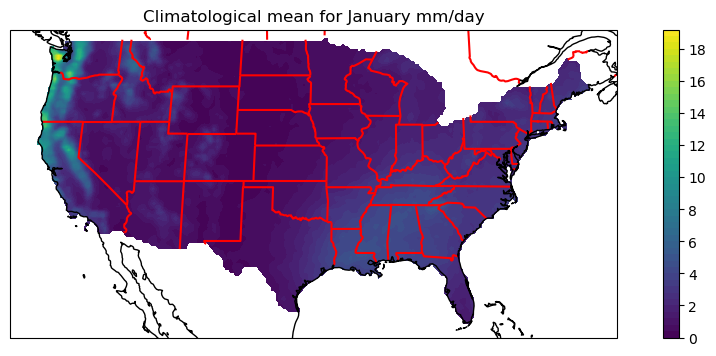

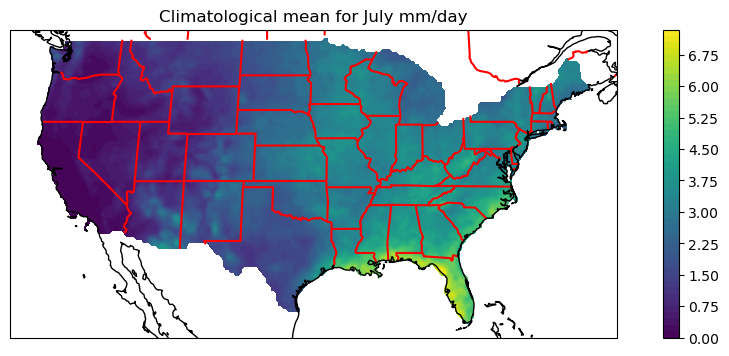

In [30]:
# let's try to plot a monthly mean
import cartopy.feature as cfeature

scale = '50m'
states50 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='r')




plt.figure(figsize=(12, 4), dpi=100)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-90))

plt.contourf(lon, lat, prcpm[0,:,:], 60,
             transform=ccrs.PlateCarree())
ax.add_feature(states50, zorder=1, linewidth=1.5)
ax.coastlines()
plt.colorbar()

plt.title('Climatological mean for January mm/day')
#plt.colorbar(location='bottom')
plt.show()

plt.figure(figsize=(12, 4), dpi=100)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-90))

plt.contourf(lon, lat, prcpm[6,:,:], 60,
             transform=ccrs.PlateCarree())
ax.add_feature(states50, zorder=1, linewidth=1.5)
ax.coastlines()
plt.colorbar()

plt.title('Climatological mean for July mm/day')
#plt.colorbar(location='bottom')
plt.show()

# subtract mean from each month
for i in range(0,yrmx):
    prcp[i,:,:,:] = prcp[i,:,:,:]-prcpm


## Now that we think we have the data set up, let's try some regression
Variables in hand are lat, lon, prcp(68,12,120,300) and nin(68)
All with the seasonal cycle removed
We'll do a separate regression for each month

In [31]:
#  cycle through the months
nino = np.reshape(nin,(68,12))
nmos = 12
rp = np.empty([nmos,latx,lonx])
rc = np.empty([nmos,latx,lonx])
for i in range(nmos):  # range is 0, 1, ... 11
    p = prcp[:,i,:,:]
    n = nino[:,i]
    # first remove means from both monthly series
    pm = np.nanmean(p,0)
    ps = np.std(p,0)
    nm = np.nanmean(n,0)
    ns = np.std(n,0)
    n = (n - nm)/ns   # here we also standardize nino by dividing by standard deviation
    for j in range(yrmx):
        p[j,:,:] = p[j,:,:] - pm
    # now we can do a simple matrix multiply to get regression
    #print('nm ',nm,',  ns ',ns)
    #print('shape n ',np.shape(n),',  shape p ',np.shape(p))
    pr = np.reshape(p,(yrmx,latx*lonx))
    ps = np.reshape(ps,(latx*lonx))
    #r=n.dot(pr.transpose())
    r=n.dot(pr)/yrmx
    c=np.divide(r,ps)  # compute correlation
    #print('shape r ',np.shape(r),',  shape pr ',np.shape(pr))
    rp[i,:,:] = np.reshape(r,(latx,lonx))
    rc[i,:,:] = np.reshape(c,(latx,lonx))

/home/disk/eos10/dennis/anaconda3/envs/atms552/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


## Map some of our regressions

In [32]:
# what is the sigificance of these things
# t = r*sqrt(N-1)/sqrt(1-r^2)  for r_real = 0,   N=68
import scipy.stats as stats
np.set_printoptions(precision=2)
rx = 0.1
for i in range(10):
    n = 68
    tx = rx*np.sqrt(n-1)/np.sqrt(1 - rx*rx)
    print('r = ','%.2f' %rx,', n = ',n,', t = ','%.2f' %tx)
    rx = rx + 0.05
tcrit = stats.t.ppf(q=1-.025,df=n-1)
print('tcrit = ','%.2f' %tcrit)
# so to reject a null hypothesis that the correlation is zero at p=0.05, we need a correlation greater than 0.2 or so
# this does not take into account that we are giving it 120x360 grid points to succeed on.
# A more useful though may be how high a correlation we want for making predictions.
# the highesst correlation we are going to get is about 0.5, so at most 25% of the variance for the dependent sample

r =  0.10 , n =  68 , t =  0.82
r =  0.15 , n =  68 , t =  1.24
r =  0.20 , n =  68 , t =  1.67
r =  0.25 , n =  68 , t =  2.11
r =  0.30 , n =  68 , t =  2.57
r =  0.35 , n =  68 , t =  3.06
r =  0.40 , n =  68 , t =  3.57
r =  0.45 , n =  68 , t =  4.12
r =  0.50 , n =  68 , t =  4.73
r =  0.55 , n =  68 , t =  5.39
tcrit =  2.00


## Statistical Comment
From the above table, to reject a null hypothesis that the correlation is zero at p=0.05, we need a correlation greater than ~0.25 or so
This does not take into account that we are giving it 120x360 grid points to succeed on.
A more useful thought may be how high a correlation we want for making predictions.
The highesst correlation we are going to get below is about 0.5, so at most 25% of the variance for the dependent sample

cmax  0.6595068718823437 ,  rmax  2.6303675298944795 0.6595068718823437  -  2.6303675298944795


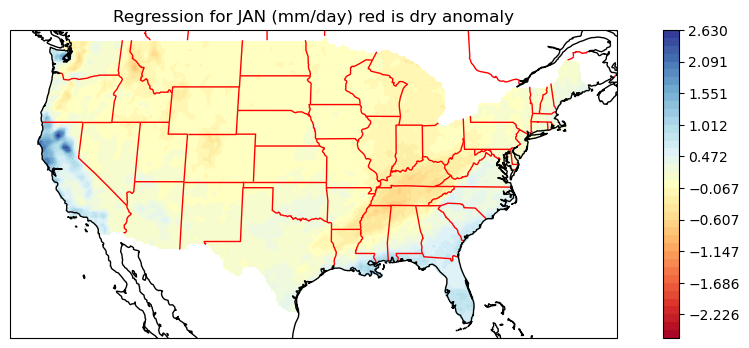

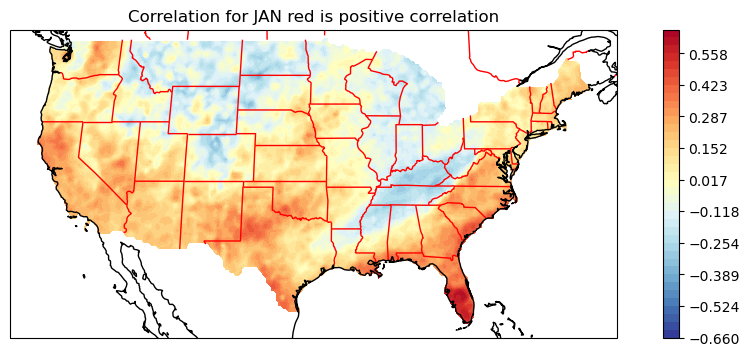

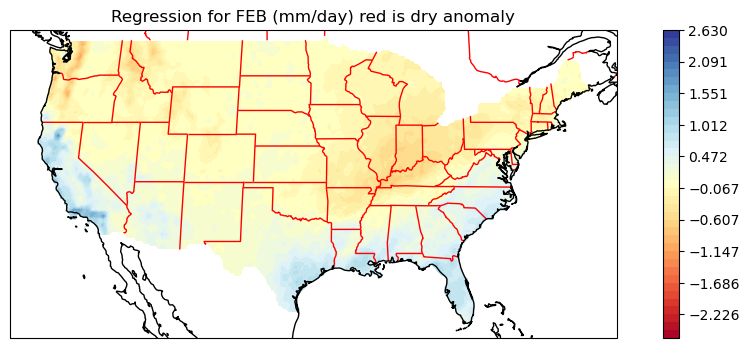

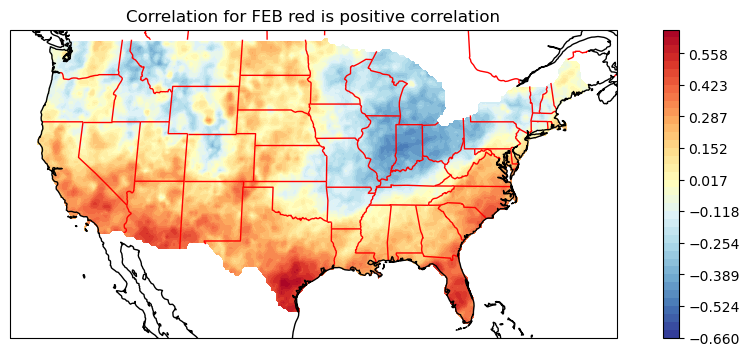

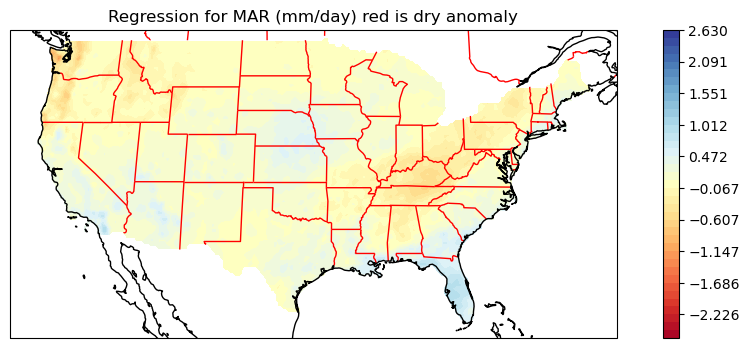

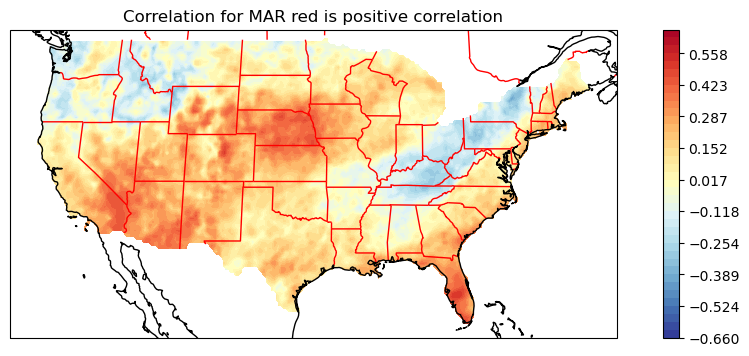

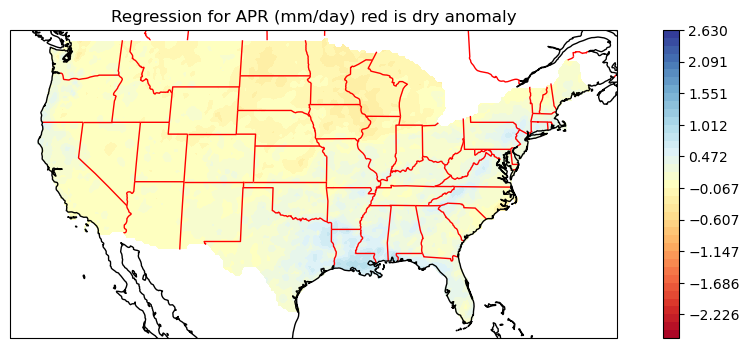

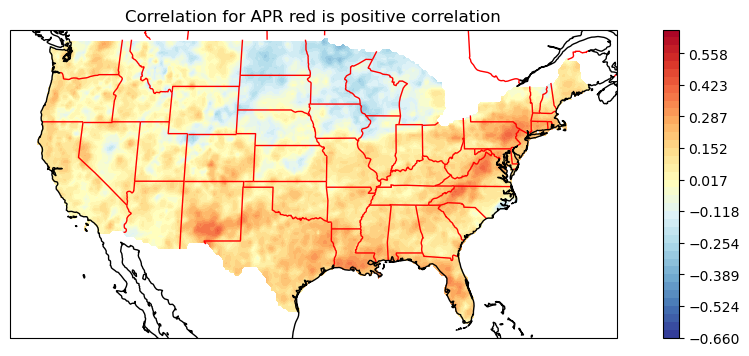

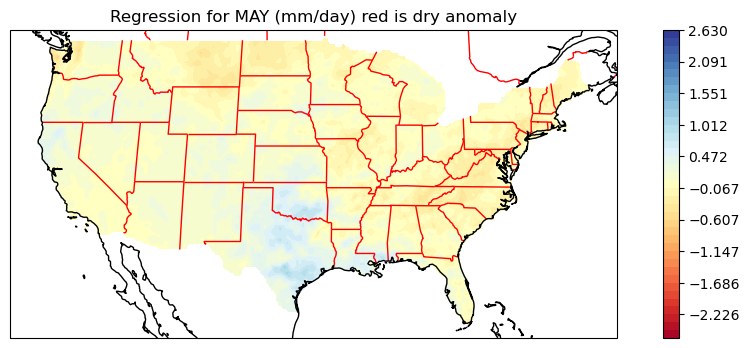

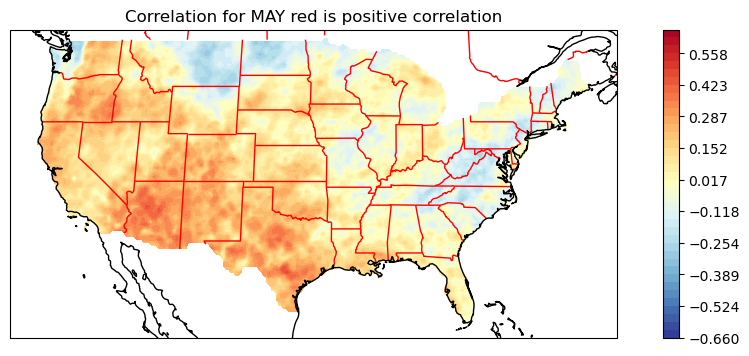

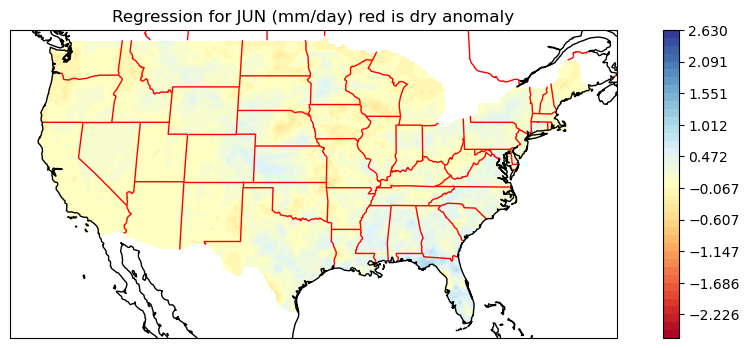

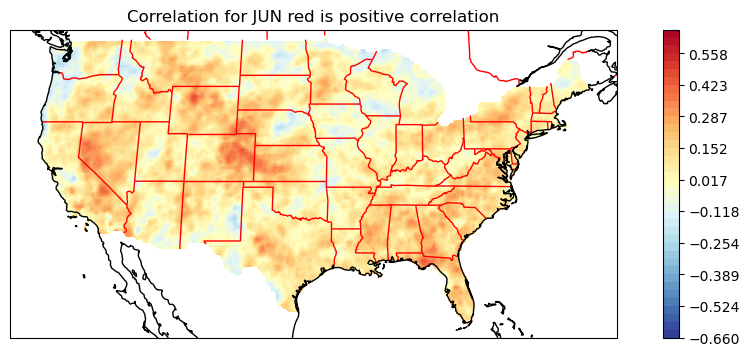

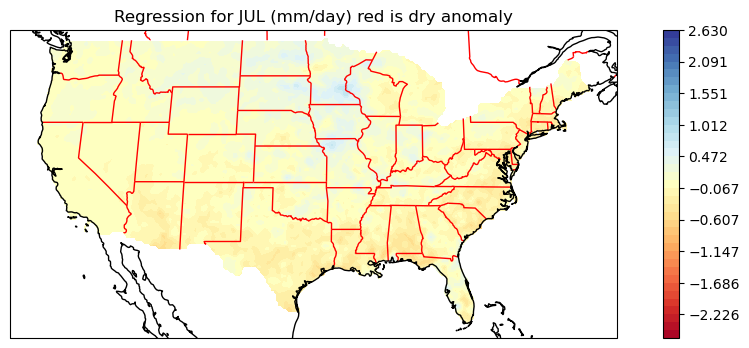

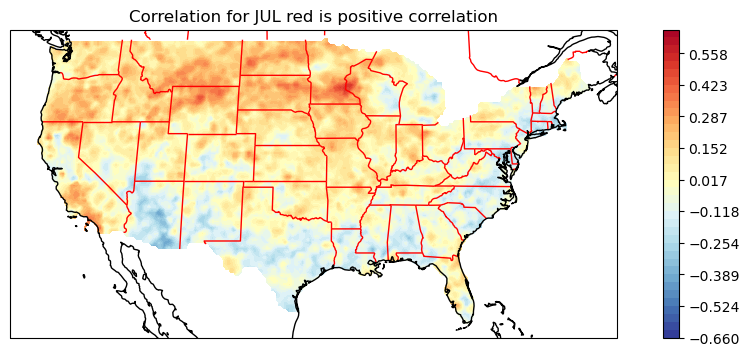

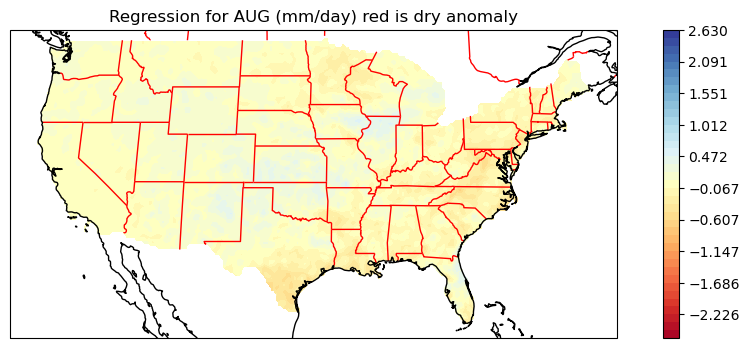

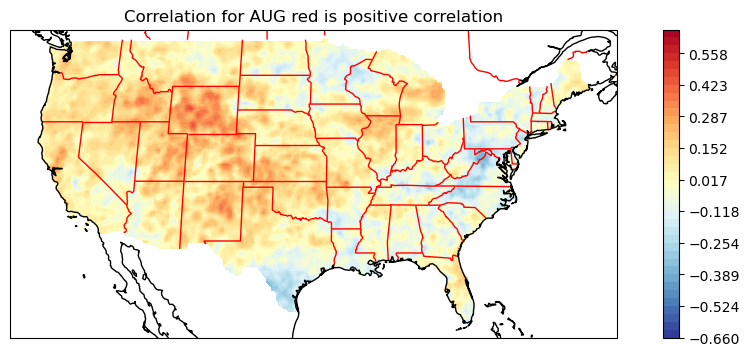

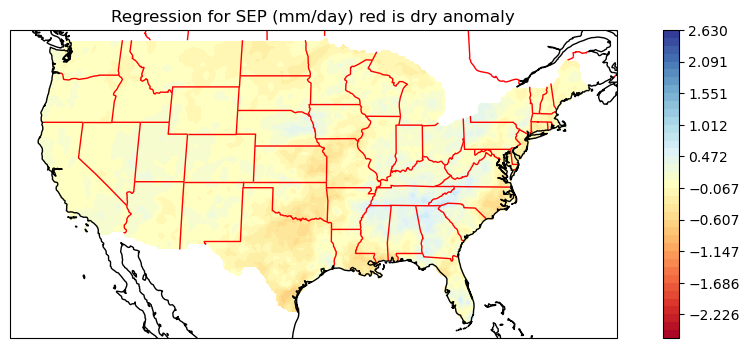

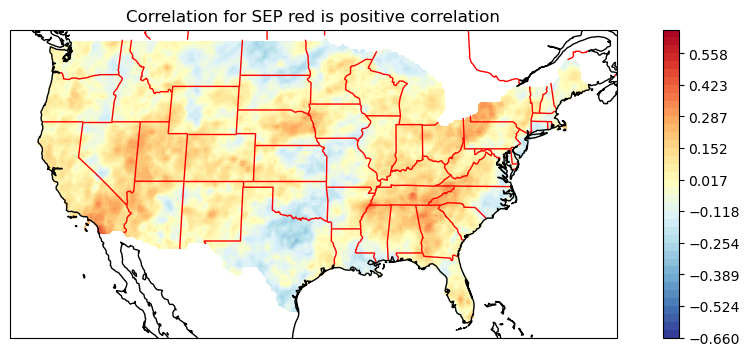

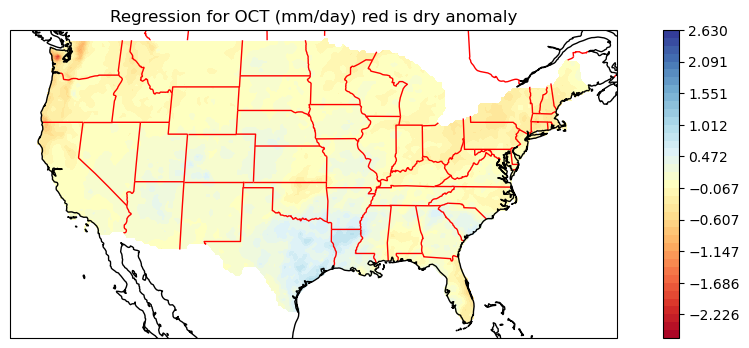

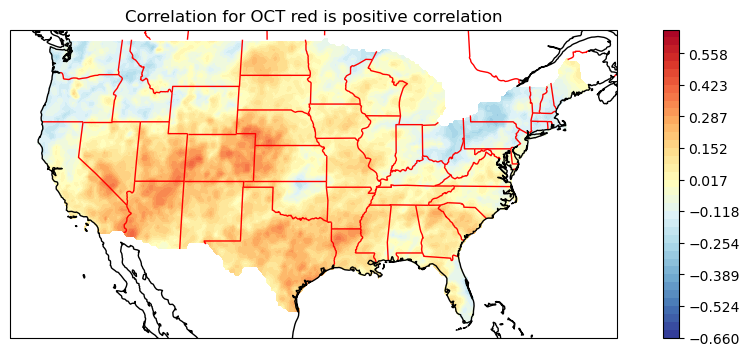

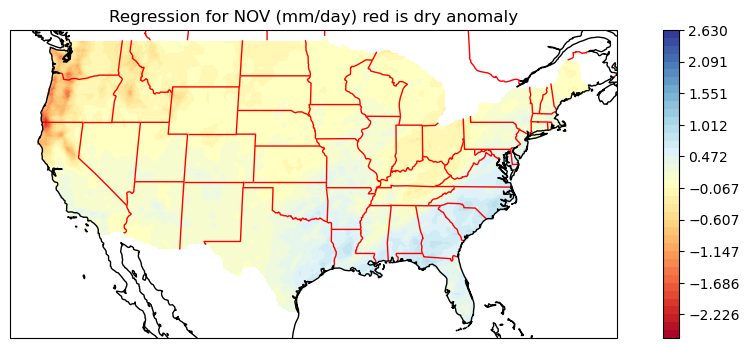

In [ ]:
# contour plot some regressions
mnames = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
#col_map = 'coolwarm'
col_mapc = 'RdYlBu_r'
col_mapr = 'RdYlBu'
cmax = np.nanmax(np.abs(rc))  # here I am finding the maximum value, then I will fix the contours and colorbar to be constant across months
rmax = np.nanmax(np.abs(rp))
nconts=40
contc = np.linspace(-cmax,cmax,nconts)  
contr = np.linspace(-rmax,rmax,nconts)
print('cmax ',cmax,',  rmax ',rmax, np.max(contc),' - ',np.max(contr))
for i in range(nmos):
    plt.figure(figsize=(12, 4), dpi=100)
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-90))

    plt.contourf(lon, lat, rp[i,:,:], contr, cmap=col_mapr,
             transform=ccrs.PlateCarree())
    ax.add_feature(states50, zorder=1, linewidth=1.0)
    ax.coastlines()
    plt.colorbar()
    #plt.clim(contr[0],contr[nconts-1])
    plt.title('Regression for ' + mnames[i] + ' (mm/day) red is dry anomaly')
    #plt.colorbar(location='bottom')
    plt.show()

    # also plot correlation
 
    plt.figure(figsize=(12, 4), dpi=100)
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-90))

    plt.contourf(lon, lat, rc[i,:,:], contc, cmap=col_mapc,
             transform=ccrs.PlateCarree())
    ax.add_feature(states50, zorder=1, linewidth=1.0)
    ax.coastlines()
    plt.colorbar()
    #plt.clim(contc[0],contc[nconts-1])
    plt.title('Correlation for ' + mnames[i] + ' red is positive correlation')
    #plt.colorbar(location='bottom')
    plt.show()

